## Detecting Pneumonia
The following notebook will create an algorithm to detech pneumonia from CT-scans of the thorax.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os

from IPython.display import display



ds_train = keras.preprocessing.image_dataset_from_directory(
    '../dataset/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_valid = keras.preprocessing.image_dataset_from_directory(
    '../dataset/val',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [5]:
#Data augmentation
keras.layers.experimental.preprocessing.RandomTranslation(
    (-0.2, 0.3),
    (-0.2, 0.3),
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    name=None
)

In [13]:
# Models
model = keras.Sequential([
    
    # First conv block
    layers.Conv2D(
        filters=32, 
        kernel_size=5, 
        activation="relu", 
        padding="same", 
        input_shape=[128, 128, 3]
    ),
    layers.MaxPool2D(),
    
    # Second conv block
    layers.Conv2D(
        filters=64, 
        kernel_size=3, 
        activation="relu", 
        padding='same'
    ),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 393222    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [22]:
# With 17 epochs, takes almost 10mns to run on my Mac
model.compile(
    optimizer = keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=17,
    verbose=0
)

KeyboardInterrupt: 

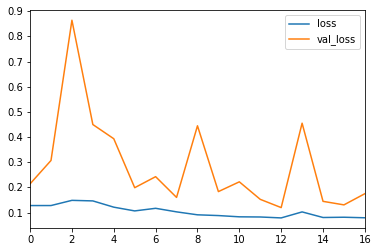

In [20]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()

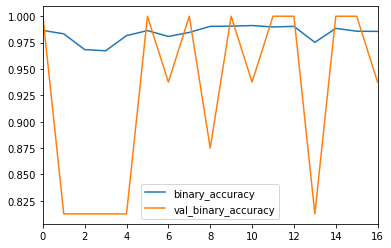

In [21]:
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

Ran with 12 epochs and then 17 epochs but the model is far too demanding for a laptop. 

Results seems to work well on the training data (blue lines) with low loss and high accuracy, however the images show high volatility with the test data (orange lines). Fitting the model with 12 epochs resulted in test accuracy much less volatile, however still well below training data (too much overfitting)

## k-Nearest Neighbors

Based off this <a href="https://www.pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification/">article</a>

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import argparse
import pathlib
import os
import jwt
import cv2
import numpy as np
import imutils

def image_to_feature_vector(image, size=(64, 64)):
    return cv2.resize(image, size).flatten()

# get images
def get_image_paths(rootPath):
    imagePaths = []
    for file in os.listdir(rootPath):
        if(file[0] == '.'): continue
        for f in os.listdir(rootPath+file):
            if(f[0] == '.'): continue
            imagePaths.append(os.path.abspath(rootPath+'/'+file+'/'+f))
#             print(os.path.abspath(file+'/'+f).split(os.path.sep)[-2])
    return imagePaths

def extract_color_histogram(image, bins=(8, 8, 8)):
	# extract a 3D color histogram from the HSV color space using
	# the supplied number of `bins` per channel
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 180, 0, 256, 0, 256])
	# handle normalizing the histogram if we are using OpenCV 2.4.X
	if imutils.is_cv2():
		hist = cv2.normalize(hist)
	# otherwise, perform "in place" normalization in OpenCV 3 (I
	# personally hate the way this is done
	else:
		cv2.normalize(hist, hist)
	# return the flattened histogram as the feature vector
	return hist.flatten()

all_images = get_image_paths('../dataset/train/')

rawImages = []
features = []
labels = []
files = []

for (i, imagePath) in enumerate(all_images):
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-2]
    file = imagePath.split(os.path.sep)[-1]
    
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
    
    rawImages.append(pixels)
    features.append(hist)
    labels.append(label)
    files.append(file)
    
    if i > 0 and i % 500 == 0:
        print("[INFO] processed {}/{}".format(i, len(all_images)))

rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(
	rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
	features.nbytes / (1024 * 1000.0)))

(trainRI, testRI, trainRL, testRL) = train_test_split(
	rawImages, labels, test_size=0.25, random_state=42)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
	features, labels, test_size=0.25, random_state=42)

# train and evaluate a k-NN classifer on the raw pixel intensities
print("[INFO] evaluating raw pixel accuracy...")
ri_model = KNeighborsClassifier(n_neighbors=1)
ri_model.fit(trainRI, trainRL)
ri_acc = ri_model.score(testRI, testRL)
print("[INFO] raw pixel accuracy: {:.2f}%".format(ri_acc * 100))

# train and evaluate a k-NN classifer on the histogram
# representations
print("[INFO] evaluating histogram accuracy...")
fea_model = KNeighborsClassifier(n_neighbors=1)
fea_model.fit(trainFeat, trainLabels)
fea_acc = fea_model.score(testFeat, testLabels)
print("[INFO] histogram accuracy: {:.2f}%".format(fea_acc * 100))


[INFO] processed 500/5216
[INFO] processed 1000/5216
[INFO] processed 1500/5216
[INFO] processed 2000/5216
[INFO] processed 2500/5216
[INFO] processed 3000/5216
[INFO] processed 3500/5216
[INFO] processed 4000/5216
[INFO] processed 4500/5216
[INFO] processed 5000/5216
[INFO] pixels matrix: 62.59MB
[INFO] features matrix: 10.43MB
[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 81.67%
[INFO] evaluating histogram accuracy...
[INFO] histogram accuracy: 81.67%


In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_pairwise():
    data = np.array(testFeat[:,1], testLabels)
    df = pd.DataFrame(data)
    print(df.head())
    plt.figure()
    sns.pairplot(df, hue = "Pneumonia", height=2, markers=["pn", "N"])
    plt.show()
    
data = np.array([testFeat[:,1], testLabels])
y_score = model.predict_proba(testFeat)[:, 1]
print(testFeat[:,1].shape)
df = pd.DataFrame(y_score)
print(df.head())

(1304,)
     0
0  1.0
1  1.0
2  0.0
3  0.0
4  1.0


In [36]:
import plotly.express as px


def plot_spread():
    y_score = ri_model.predict_proba(testRI)[:, 1]

    fig = px.scatter(
        testRI, x=0, y=1,
        color=y_score, color_continuous_scale='RdBu',
        symbol=testRL, symbol_map={'0': 'square-dot', '1': 'circle-dot'},
        labels={'symbol': 'label', 'color': 'score of <br>first class'}
    )
    fig.update_traces(marker_size=12, marker_line_width=1.5)
    fig.update_layout(legend_orientation='h')
    fig.show()

print(features.shape)
print(labels.shape)

plot_spread()

# def plot_density()

(5216, 512)
(5216,)


For more graphs see this <a href="https://plotly.com/python/knn-classification/">article</a>

In [65]:
print(trainFeat.shape)
print(features.shape)
print(features[:3912].shape)

print(model.predict(features[0].reshape(1,-1)))
A = model.kneighbors_graph(features)
b = A.toarray()

(3912, 512)
(5216, 512)
(3912, 512)
['PNEUMONIA']


In [29]:
print(files[0])
predictions = model.predict(features[:3912])
probabilities = model.predict_proba(features[:3912])
results = zip(files[:3912], predictions, probabilities)
print(results)

person63_bacteria_306.jpeg


In [30]:
count = 0
show = 0
for file, prediction, proba in results:
    if count % 100 == 0: 
        print(file, prediction, proba)
#         show += 1
#     count += 1
#     if show == 20: break

person63_bacteria_306.jpeg PNEUMONIA [0. 1.]
person1438_bacteria_3721.jpeg PNEUMONIA [0. 1.]
person755_bacteria_2659.jpeg PNEUMONIA [0. 1.]
person478_virus_975.jpeg PNEUMONIA [0. 1.]
person661_bacteria_2553.jpeg PNEUMONIA [0. 1.]
person276_bacteria_1296.jpeg PNEUMONIA [0. 1.]
person1214_bacteria_3166.jpeg PNEUMONIA [0. 1.]
person1353_virus_2333.jpeg PNEUMONIA [0. 1.]
person26_bacteria_122.jpeg PNEUMONIA [0. 1.]
person124_virus_238.jpeg PNEUMONIA [0. 1.]
person1619_bacteria_4261.jpeg PNEUMONIA [0. 1.]
person890_bacteria_2814.jpeg PNEUMONIA [0. 1.]
person1514_bacteria_3964.jpeg PNEUMONIA [0. 1.]
person1491_bacteria_3893.jpeg PNEUMONIA [0. 1.]
person69_bacteria_338.jpeg PNEUMONIA [0. 1.]
person321_bacteria_1489.jpeg PNEUMONIA [0. 1.]
person281_bacteria_1329.jpeg PNEUMONIA [0. 1.]
person688_bacteria_2584.jpeg PNEUMONIA [0. 1.]
person1598_bacteria_4197.jpeg PNEUMONIA [0. 1.]
person535_virus_1062.jpeg PNEUMONIA [0. 1.]
person1222_bacteria_3177.jpeg PNEUMONIA [0. 1.]
person581_bacteria_2392.j

person779_virus_1410.jpeg PNEUMONIA [0. 1.]
person419_bacteria_1845.jpeg PNEUMONIA [0. 1.]
person701_virus_1297.jpeg PNEUMONIA [0. 1.]
person366_virus_746.jpeg PNEUMONIA [0. 1.]
person7_bacteria_28.jpeg PNEUMONIA [0. 1.]
person978_virus_1653.jpeg PNEUMONIA [0. 1.]
person1737_bacteria_4573.jpeg PNEUMONIA [0. 1.]
person1451_virus_2479.jpeg PNEUMONIA [0. 1.]
person326_bacteria_1506.jpeg PNEUMONIA [0. 1.]
person370_bacteria_1691.jpeg PNEUMONIA [0. 1.]
person81_virus_153.jpeg PNEUMONIA [0. 1.]
person1488_virus_2587.jpeg PNEUMONIA [0. 1.]
person1597_bacteria_4194.jpeg PNEUMONIA [0. 1.]
person952_virus_1623.jpeg PNEUMONIA [0. 1.]
person1819_bacteria_4677.jpeg PNEUMONIA [0. 1.]
person419_bacteria_1844.jpeg PNEUMONIA [0. 1.]
person1328_virus_2293.jpeg PNEUMONIA [0. 1.]
person1121_virus_1846.jpeg PNEUMONIA [0. 1.]
person1180_virus_2011.jpeg PNEUMONIA [0. 1.]
person1484_virus_2577.jpeg PNEUMONIA [0. 1.]
person602_bacteria_2460.jpeg PNEUMONIA [0. 1.]
person1453_bacteria_3771.jpeg PNEUMONIA [0. 1.]

person866_bacteria_2788.jpeg PNEUMONIA [0. 1.]
person1430_bacteria_3696.jpeg PNEUMONIA [0. 1.]
person155_virus_307.jpeg PNEUMONIA [0. 1.]
person1349_bacteria_3438.jpeg PNEUMONIA [0. 1.]
person1242_virus_2109.jpeg PNEUMONIA [0. 1.]
person16_bacteria_53.jpeg PNEUMONIA [0. 1.]
person606_bacteria_2469.jpeg PNEUMONIA [0. 1.]
person548_bacteria_2299.jpeg PNEUMONIA [0. 1.]
person357_virus_735.jpeg PNEUMONIA [0. 1.]
person1418_virus_2429.jpeg PNEUMONIA [0. 1.]
person1567_virus_2722.jpeg PNEUMONIA [0. 1.]
person817_bacteria_2728.jpeg PNEUMONIA [0. 1.]
person368_bacteria_1678.jpeg PNEUMONIA [0. 1.]
person97_virus_180.jpeg PNEUMONIA [0. 1.]
person382_bacteria_1745.jpeg PNEUMONIA [0. 1.]
person1555_bacteria_4060.jpeg PNEUMONIA [0. 1.]
person162_virus_322.jpeg PNEUMONIA [0. 1.]
person1123_virus_1848.jpeg PNEUMONIA [0. 1.]
person523_virus_1043.jpeg PNEUMONIA [0. 1.]
person504_bacteria_2130.jpeg PNEUMONIA [0. 1.]
person332_bacteria_1535.jpeg PNEUMONIA [0. 1.]
person1609_bacteria_4237.jpeg PNEUMONIA [

person1157_bacteria_3102.jpeg PNEUMONIA [0. 1.]
person1068_bacteria_3002.jpeg PNEUMONIA [0. 1.]
person1476_bacteria_3843.jpeg PNEUMONIA [0. 1.]
person382_bacteria_1739.jpeg PNEUMONIA [0. 1.]
person923_bacteria_2848.jpeg PNEUMONIA [0. 1.]
person563_bacteria_2333.jpeg PNEUMONIA [0. 1.]
person876_bacteria_2799.jpeg PNEUMONIA [0. 1.]
person609_virus_1176.jpeg PNEUMONIA [0. 1.]
person2_bacteria_3.jpeg PNEUMONIA [0. 1.]
person529_bacteria_2228.jpeg PNEUMONIA [0. 1.]
person1000_bacteria_2931.jpeg PNEUMONIA [0. 1.]
person349_bacteria_1607.jpeg PNEUMONIA [0. 1.]
person1177_virus_2000.jpeg PNEUMONIA [0. 1.]
person1320_bacteria_3342.jpeg PNEUMONIA [0. 1.]
person110_virus_207.jpeg PNEUMONIA [0. 1.]
person539_bacteria_2269.jpeg PNEUMONIA [0. 1.]
person19_bacteria_59.jpeg PNEUMONIA [0. 1.]
person1597_bacteria_4189.jpeg PNEUMONIA [0. 1.]
person524_virus_1045.jpeg PNEUMONIA [0. 1.]
person1227_bacteria_3182.jpeg PNEUMONIA [0. 1.]
person1019_virus_1707.jpeg PNEUMONIA [0. 1.]
person702_bacteria_2601.jpeg

person413_bacteria_1831.jpeg PNEUMONIA [0. 1.]
person1816_bacteria_4673.jpeg PNEUMONIA [0. 1.]
person416_bacteria_1840.jpeg PNEUMONIA [0. 1.]
person471_bacteria_2005.jpeg PNEUMONIA [0. 1.]
person489_bacteria_2065.jpeg PNEUMONIA [0. 1.]
person906_virus_1562.jpeg PNEUMONIA [0. 1.]
person266_bacteria_1244.jpeg PNEUMONIA [0. 1.]
person1274_virus_2193.jpeg PNEUMONIA [0. 1.]
person581_bacteria_2395.jpeg PNEUMONIA [0. 1.]
person1331_virus_2299.jpeg PNEUMONIA [0. 1.]
person1661_bacteria_4406.jpeg PNEUMONIA [0. 1.]
person1665_bacteria_4415.jpeg PNEUMONIA [0. 1.]
person836_virus_1473.jpeg PNEUMONIA [0. 1.]
person1619_bacteria_4266.jpeg PNEUMONIA [0. 1.]
person420_bacteria_1851.jpeg PNEUMONIA [0. 1.]
person589_bacteria_2425.jpeg PNEUMONIA [0. 1.]
person534_bacteria_2252.jpeg PNEUMONIA [0. 1.]
person1562_bacteria_4078.jpeg PNEUMONIA [0. 1.]
person802_bacteria_2708.jpeg PNEUMONIA [0. 1.]
person902_bacteria_2827.jpeg PNEUMONIA [0. 1.]
person825_bacteria_2736.jpeg PNEUMONIA [0. 1.]
person1733_bacteri

person976_virus_1651.jpeg PNEUMONIA [0. 1.]
person23_bacteria_106.jpeg PNEUMONIA [0. 1.]
person1486_bacteria_3885.jpeg PNEUMONIA [0. 1.]
person1449_bacteria_3746.jpeg PNEUMONIA [0. 1.]
person584_virus_1128.jpeg PNEUMONIA [0. 1.]
person337_bacteria_1557.jpeg PNEUMONIA [0. 1.]
person88_virus_161.jpeg PNEUMONIA [0. 1.]
person255_bacteria_1175.jpeg PNEUMONIA [0. 1.]
person498_bacteria_2100.jpeg PNEUMONIA [0. 1.]
person402_bacteria_1811.jpeg PNEUMONIA [0. 1.]
person1729_bacteria_4557.jpeg PNEUMONIA [0. 1.]
person161_virus_317.jpeg PNEUMONIA [0. 1.]
person25_bacteria_121.jpeg PNEUMONIA [0. 1.]
person295_bacteria_1390.jpeg PNEUMONIA [0. 1.]
person1084_bacteria_3024.jpeg PNEUMONIA [0. 1.]
person392_bacteria_1783.jpeg PNEUMONIA [0. 1.]
person1396_virus_2399.jpeg PNEUMONIA [0. 1.]
person124_virus_247.jpeg PNEUMONIA [0. 1.]
person387_bacteria_1770.jpeg PNEUMONIA [0. 1.]
person1590_bacteria_4176.jpeg PNEUMONIA [0. 1.]
person629_bacteria_2507.jpeg PNEUMONIA [0. 1.]
person958_bacteria_2883.jpeg PNEU

person1564_virus_2719.jpeg PNEUMONIA [0. 1.]
person670_virus_1259.jpeg PNEUMONIA [0. 1.]
person25_bacteria_120.jpeg PNEUMONIA [0. 1.]
person637_virus_1218.jpeg PNEUMONIA [0. 1.]
person124_virus_246.jpeg PNEUMONIA [0. 1.]
person1100_virus_1820.jpeg PNEUMONIA [0. 1.]
person1414_virus_2424.jpeg PNEUMONIA [0. 1.]
person1670_bacteria_4427.jpeg PNEUMONIA [0. 1.]
person1630_bacteria_4304.jpeg PNEUMONIA [0. 1.]
person438_virus_889.jpeg PNEUMONIA [0. 1.]
person1324_virus_2284.jpeg PNEUMONIA [0. 1.]
person23_bacteria_107.jpeg PNEUMONIA [0. 1.]
person809_bacteria_2717.jpeg PNEUMONIA [0. 1.]
person575_virus_1119.jpeg PNEUMONIA [0. 1.]
person1449_bacteria_3747.jpeg PNEUMONIA [0. 1.]
person1486_bacteria_3884.jpeg PNEUMONIA [0. 1.]
person313_virus_637.jpeg PNEUMONIA [0. 1.]
person732_bacteria_2634.jpeg PNEUMONIA [0. 1.]
person1923_bacteria_4831.jpeg PNEUMONIA [0. 1.]
person66_bacteria_323.jpeg PNEUMONIA [0. 1.]
person448_virus_922.jpeg PNEUMONIA [0. 1.]
person838_virus_1476.jpeg PNEUMONIA [0. 1.]
per

person741_virus_1364.jpeg PNEUMONIA [0. 1.]
person492_virus_998.jpeg PNEUMONIA [0. 1.]
person553_bacteria_2317.jpeg PNEUMONIA [0. 1.]
person563_bacteria_2337.jpeg PNEUMONIA [0. 1.]
person311_bacteria_1452.jpeg PNEUMONIA [0. 1.]
person653_bacteria_2545.jpeg PNEUMONIA [0. 1.]
person587_bacteria_2421.jpeg PNEUMONIA [0. 1.]
person481_virus_983.jpeg PNEUMONIA [0. 1.]
person262_virus_544.jpeg PNEUMONIA [0. 1.]
person1375_bacteria_3510.jpeg PNEUMONIA [0. 1.]
person341_bacteria_1577.jpeg PNEUMONIA [0. 1.]
person1358_virus_2339.jpeg PNEUMONIA [0. 1.]
person1935_bacteria_4850.jpeg PNEUMONIA [0. 1.]
person18_bacteria_57.jpeg PNEUMONIA [0. 1.]
person1643_bacteria_4354.jpeg PNEUMONIA [0. 1.]
person1473_bacteria_3836.jpeg PNEUMONIA [0. 1.]
person359_bacteria_1642.jpeg PNEUMONIA [0. 1.]
person1408_bacteria_3579.jpeg PNEUMONIA [0. 1.]
person5_bacteria_19.jpeg PNEUMONIA [0. 1.]
person23_bacteria_89.jpeg PNEUMONIA [0. 1.]
person669_bacteria_2561.jpeg PNEUMONIA [0. 1.]
person539_virus_1069.jpeg PNEUMONIA

person1677_bacteria_4444.jpeg PNEUMONIA [0. 1.]
person788_virus_1419.jpeg PNEUMONIA [0. 1.]
person1904_bacteria_4798.jpeg PNEUMONIA [0. 1.]
person706_virus_1304.jpeg PNEUMONIA [0. 1.]
person1537_bacteria_4020.jpeg PNEUMONIA [0. 1.]
person1537_virus_2674.jpeg PNEUMONIA [0. 1.]
person723_virus_1342.jpeg PNEUMONIA [0. 1.]
person522_bacteria_2210.jpeg PNEUMONIA [0. 1.]
person1054_bacteria_2988.jpeg PNEUMONIA [0. 1.]
person98_virus_182.jpeg PNEUMONIA [0. 1.]
person502_bacteria_2123.jpeg PNEUMONIA [0. 1.]
person1482_virus_2573.jpeg PNEUMONIA [0. 1.]
person358_virus_737.jpeg PNEUMONIA [0. 1.]
person67_bacteria_332.jpeg PNEUMONIA [0. 1.]
person1191_virus_2032.jpeg NORMAL [1. 0.]
person419_virus_855.jpeg PNEUMONIA [0. 1.]
person1429_virus_2443.jpeg PNEUMONIA [0. 1.]
person369_bacteria_1680.jpeg PNEUMONIA [0. 1.]
person319_bacteria_1479.jpeg PNEUMONIA [0. 1.]
person927_bacteria_2852.jpeg PNEUMONIA [0. 1.]
person640_bacteria_2532.jpeg PNEUMONIA [0. 1.]
person1505_virus_2615.jpeg PNEUMONIA [0. 1.]

#### Results
<table style="display:inline-block">
    <tr>
        <td>Run #</td>
        <td>k</td>
        <td>Raw Pixel Acc</td>
        <td>Histogram Acc</td>
    </tr>
    <tr>
        <td>1</td>
        <td>3</td>
        <td>91.03%</td>
        <td>83.28%</td>
    </tr>
    <tr>
        <td>2</td>
        <td>1</td>
        <td>90.95%</td>
        <td>81.67%</td>
    </tr>
    <tr>
        <td>3</td>
        <td>7</td>
        <td>91.18%</td>
        <td>84.28%</td>
    </tr>
</table>
<p style="display:block">
    Still have to look into how exactly this accuracy is calculated and if I'm doing it right...
    Should also add cross validation
</p>

## Support Vector Machine (SVM)

In [1]:
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image as keras_image
import cv2
from pathlib import Path
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
import pandas as pd
import os
from builtins import range

In [14]:
def load_image_files(rootPath):
    train_img = []
    for file in os.listdir(rootPath):
        if(file[0] == '.'): continue
        for f in os.listdir(rootPath+file):
            if(f[0] == '.'): continue
            img = imread(os.path.abspath(rootPath+'/'+file+'/'+f))
            #some images have colour chanels and others not
            if len(img.shape) > 2:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.squeeze(img)
            img_pred = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA)
            img_pred = img_pred[:, :]
            img_pred = keras_image.img_to_array(img_pred)
            img_pred = img_pred / 255
            train_img.append(img_pred)
            
    X = np.array(train_img)
    return X


labels = []
labelCounts = [0,0]

X = load_image_files('../dataset/train/')

print("X shape: "+str(X.shape))

y0 = np.zeros(3875)
y1 = np.ones(1341)
# concatenate y0 and y1 to form y
y = []
y = np.concatenate((y0, y1), axis=0)

X shape: (5216, 50, 50, 1)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.5)
print("X_train: " + str(X_train.shape))
print("X_test: " + str(X_test.shape))
print("X_val: " + str(X_val.shape))
print("y_train: " + str(y_train.shape))
print("y_test: " + str(y_test.shape))
print("y_val: " + str(y_val.shape))

X_train: (4172, 50, 50, 1)
X_test: (522, 50, 50, 1)
X_val: (522, 50, 50, 1)
y_train: (4172,)
y_test: (522,)
y_val: (522,)


In [33]:
a = list(range(10))
b = np.zeros((12,2))
print(b[a])
print(b)
b = [[[0,1,2,3],[4,5,6,7,8],[9,10,11,12],[13,14,15,16],[17,18,19]]]

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [17]:
# take only the length of the 1st dimension for each
num_training = X_train.shape[0]
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]
num_test = X_test.shape[0]
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
num_val = X_val.shape[0]
mask = list(range(num_val))
X_val = X_val[mask]
y_val = y_val[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(4172, 2500) (522, 2500) (522, 2500)
(4172,) (522,) (522,)


In [18]:
# Getting data to zero mean, i.e centred around zero.
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_val -= mean_image
# append the bias dimension of ones (i.e. bias trick) so that our   # SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
print(X_train.shape, X_test.shape, X_val.shape)
print("Data ready")

(4172, 2501) (522, 2501) (522, 2501)
Data ready


In [21]:
from __future__ import print_function
from builtins import object
# for svm_loss_vectorized

def svm_loss_vectorized(W, X, y, reg):
    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero
    num_classes = W.shape[1]
    num_train = X.shape[0]
    scores = X.dot(W)
    y = [int(x) for x in y]
    correct_class_scores = scores[np.arange(num_train), y].reshape(num_train, 1)
    margin = np.maximum(0, scores - correct_class_scores + 1)
    margin[np.arange(num_train), y] = 0  # do not consider correct class in loss
    loss = margin.sum() / num_train
    # Add regularization to the loss.
    loss += reg * np.sum(W * W)

    margin[margin > 0] = 1
    valid_margin = margin.sum(axis=1)
    margin[np.arange(num_train), y] -= valid_margin
    dW = (X.T).dot(margin) / num_train
    # dW /= num_train
    # Regularization gradient
    dW = dW + reg * 2 * W
    return loss, dW


class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):

        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim, int(num_classes))
        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            batch_indices = np.random.choice(num_train, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch=y[batch_indices]

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          #

            self.W -= learning_rate*grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        y_pred = scores.argmax(axis=1)
        return y_pred


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [22]:
svmd = LinearSVM()
loss_hist = svmd.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=False)

y_train_pred = svmd.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred),))
y_val_pred = svmd.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred),))

training accuracy: 0.838447
validation accuracy: 0.852490


In [4]:
### Jupyter is being annoying and not connecting to my terminal installs

# import sys
# !{sys.executable} -m pip install plotly

  Using cached plotly-4.14.3-py2.py3-none-any.whl (13.2 MB)
  Using cached retrying-1.3.3.tar.gz (10 kB)
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=58eea2d8555ad8aa4be56ba31fbcb2d628a7b2c5f9a3a81133e3dff8d7d353d0
  Stored in directory: /Users/ryanheadley/Library/Caches/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
You should consider upgrading via the '/Users/ryanheadley/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
